In [27]:
# Dependencies
import pandas as pd
import numpy as np
import gmaps
import requests
from config import gkey
from config import ow_key
import time
import pprint
import pyowm
from math import sin, cos, sqrt, atan2, radians
import matplotlib.pyplot as plt

In [28]:
owm = pyowm.OWM(ow_key)
mgr = owm.agro_manager()
from pyowm.utils.geo import Polygon as GeoPolygon
mgr = owm.agro_manager()
# Configure gmaps
gmaps.configure(api_key=gkey)

In [29]:
wine_data = "winemag-data_first150k.csv"
wine_df = pd.read_csv(wine_data)
wine_df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [30]:
wine_df2=wine_df.drop(columns= ["Unnamed: 0","region_2"], axis=1)
wine_df2.head()

,country,description,designation,points,price,province,region_1,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,Provence red blend,Domaine de la Bégude


In [31]:
dropped_wine= wine_df2.dropna()
dropped_wine.count()

country        77284
description    77284
designation    77284
points         77284
price          77284
province       77284
region_1       77284
variety        77284
winery         77284
dtype: int64

In [32]:
us_data=dropped_wine[dropped_wine["country"]=="US"]
us_data

,country,description,designation,points,price,province,region_1,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Cabernet Sauvignon,Heitz
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Pinot Noir,Ponzi
8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Pinot Noir,Bergström
9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Pinot Noir,Blue Farm
11,US,"From 18-year-old vines, this supple well-balan...",Estate Vineyard Wadensvil Block,95,48.0,Oregon,Ribbon Ridge,Pinot Noir,Patricia Green Cellars
12,US,A standout even in this terrific lineup of 201...,Weber Vineyard,95,48.0,Oregon,Dundee Hills,Pinot Noir,Patricia Green Cellars
14,US,"With its sophisticated mix of mineral, acid an...",Grace Vineyard,95,185.0,Oregon,Dundee Hills,Pinot Noir,Domaine Serene
15,US,"First made in 2006, this succulent luscious Ch...",Sigrid,95,90.0,Oregon,Willamette Valley,Chardonnay,Bergström
16,US,"This blockbuster, powerhouse of a wine suggest...",Rainin Vineyard,95,325.0,California,Diamond Mountain District,Cabernet Sauvignon,Hall


In [33]:
target_area = (us_data["region_1"]+","+us_data["province"])

In [34]:
unique_variety =us_data["variety"]
#unique_variety
unique_regions =us_data["region_1"].unique()
#unique_regions

In [35]:
ratings = us_data["points"]

In [36]:
wv = pd.DataFrame({"Location": target_area,"Wine Variety": unique_variety})
wv = pd.DataFrame({"Location": target_area,"Wine Ratings": ratings})
wv_group = wv.groupby("Location")
num_varieties = pd.DataFrame(wv_group["Wine Ratings"].mean()).reset_index()
#just sampling for testing purposes
sample_num_varieties = num_varieties.sample(200)
sample_num_varieties
num_varieties.count()

Location        250
Wine Ratings    250
dtype: int64

In [37]:
# create a params dict that will be updated with new city each iteration
params = {"key": gkey}
base_url = "https://maps.googleapis.com/maps/api/geocode/json"
# Loop through the locations and run a lat/long search for each city
for idx, row in sample_num_varieties.iterrows():
#    print(idx)
    sample_target = row["Location"]
    # update address key value
    params['address'] = f"{sample_target}"
    # make request
    location_lat_lng = requests.get(base_url, params=params)
    # convert to json
    location_lat_lng = location_lat_lng.json()
    lat_long_geo = location_lat_lng["results"][0]["geometry"]
    try:
        latitude = lat_long_geo["location"]["lat"]
        longitude = lat_long_geo["location"]["lng"]
        
        
        north = latitude  + 0.01
        south = latitude  - 0.01
        east =  longitude + 0.01
        west =  longitude - 0.01
        
        try:
            gp = GeoPolygon([[
                [east, north],
                [west, north],
                [west, south],
               [east, south],
                [east, north]]])
            polygon = mgr.create_polygon(gp, 'my new shiny polygon')
            try:
                soil = mgr.soil_data(polygon) 
                sample_num_varieties.loc[idx, "Lat"] = latitude
                sample_num_varieties.loc[idx, "Lng"] = longitude  
                sample_num_varieties.loc[idx, "Soil Temperature (C) at 10 cm depth"] = soil.ten_cm_temp(unit='celsius') 
                sample_num_varieties.loc[idx, "Soil Moisture"] = soil.moisture
            except(AssertionError):
                continue
        except( pyowm.exceptions.OWMError ):
            continue
    except(KeyError, IndexError):
        print("Missing field/result... skipping.")
        continue
    time.sleep(3)
# Visualize to confirm lat lng appear
sample_num_varieties = sample_num_varieties.dropna()

In [38]:
sample_num_varieties.count()

Location                               118
Wine Ratings                           118
Lat                                    118
Lng                                    118
Soil Temperature (C) at 10 cm depth    118
Soil Moisture                          118
dtype: int64

In [39]:
sample_num_varieties.to_csv("Wine_Soil.csv")

In [40]:
post_process = pd.read_csv("Wine_Soil.csv")               

In [41]:
pnas_df = pd.read_csv("PNAS_Data/PNAS.csv")
pnas_df.head(100)

,latitude,longitude,spp_richness,N_dep_kghayr,precip_mm,temp_C_ave,pH,CL_kghayr_lower,CL_kghayr_upper,CL_kghayr,EX_kghayr,two_class_veg,NVC_1_name,NVC_2_name,NVC_Alliance,proj_orig
0,46.1,-83.7,15,5.52,805.57,5.61,7.2,15.86,19.38,17.43,-11.91,closed_canopy,Forest,Deciduous forest,Acer saccharum - Betula alleghaniensis - (Fagu...,Alvar
1,46.1,-83.7,11,5.52,805.57,5.61,7.2,15.86,19.38,17.43,-11.91,closed_canopy,Forest,Deciduous forest,Acer saccharum - Betula alleghaniensis - (Fagu...,Alvar
2,46.1,-83.7,12,5.52,805.57,5.61,7.2,15.86,19.38,17.43,-11.91,closed_canopy,Forest,Deciduous forest,Acer saccharum - Betula alleghaniensis - (Fagu...,Alvar
3,46.1,-83.7,17,5.52,805.57,5.61,7.2,15.86,19.38,17.43,-11.91,closed_canopy,Forest,Deciduous forest,Acer saccharum - Betula alleghaniensis - (Fagu...,Alvar
4,46.1,-83.7,16,5.52,805.57,5.61,7.2,15.86,19.38,17.43,-11.91,closed_canopy,Forest,Deciduous forest,Acer saccharum - Betula alleghaniensis - (Fagu...,Alvar
5,46.1,-83.7,12,5.52,805.57,5.61,7.2,15.86,19.38,17.43,-11.91,closed_canopy,Forest,Deciduous forest,Acer saccharum - Betula alleghaniensis - (Fagu...,Alvar
6,45.7,-86.6,25,5.72,732.15,5.98,7.0,8.85,9.22,9.03,-3.31,open_canopy,Shrubland,Evergreen shrubland,Juniperus communis Shrubland Alliance,Alvar
7,45.3,-83.6,19,8.89,751.28,6.67,7.3,8.98,9.35,9.16,-0.27,open_canopy,Shrubland,Evergreen shrubland,Juniperus communis Shrubland Alliance,Alvar
8,46.0,-83.7,15,8.63,782.47,5.69,7.2,15.86,19.38,17.43,-8.81,closed_canopy,Forest,Deciduous forest,Acer saccharum - Betula alleghaniensis - (Fagu...,Alvar
9,46.1,-84.9,17,7.94,822.37,5.05,5.6,13.08,15.04,13.96,-6.02,closed_canopy,Forest,Evergreen forest,Pinus strobus Forest Alliance,Alvar


In [42]:
pnas_group = pnas_df.groupby(["latitude","longitude"]).mean()
pnas_group = pnas_group.reset_index()

In [43]:
pnas_reduced = pnas_group[["latitude","longitude","precip_mm","temp_C_ave","pH"]]
pnas_reduced.count()

latitude      3739
longitude     3739
precip_mm     3739
temp_C_ave    3739
pH            3739
dtype: int64

In [44]:
pnas_dat_lat = pnas_reduced["latitude"]
pnas_dat_lng = pnas_reduced["longitude"]


radians(pnas_dat_lat[0])

0.47647488579445196

In [45]:
dist=[]
R =6373
for idx, row in post_process.iterrows():
    wine_lat = radians(row["Lat"])
    wine_lng = radians(row["Lng"])
    
    for i in range(len(pnas_dat_lat)):
            dlon = radians(pnas_dat_lng[i]) - wine_lng
            dlat = radians(pnas_dat_lat[i]) - wine_lat

            a = (sin(dlat/2))**2 + cos(wine_lat) * cos(radians(pnas_dat_lat[i])) * (sin(dlon/2))**2 
            c = 2 * atan2( sqrt(a), sqrt(1-a) ) 
            distance = R * c 
            dist.append(distance)
            
    ind = np.argmin(dist)
    post_process.loc[idx, "Precipitation(mm)"] = pnas_reduced.iloc[ind,2]
    post_process.loc[idx, "Avg. Air Temp (C)"] = pnas_reduced.iloc[ind,3]
    post_process.loc[idx, "pH(Soil)"] = pnas_reduced.iloc[ind,4]
    dist=[]
   

In [46]:
post_process.columns

Index(['Unnamed: 0', 'Location', 'Wine Ratings', 'Lat', 'Lng',
       'Soil Temperature (C) at 10 cm depth', 'Soil Moisture',
       'Precipitation(mm)', 'Avg. Air Temp (C)', 'pH(Soil)'],
      dtype='object')

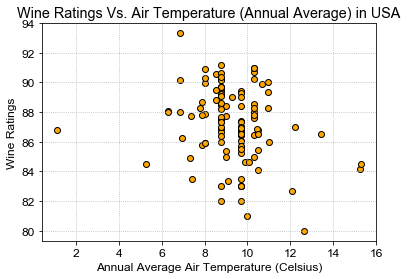

In [47]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 12
x1 = post_process["Avg. Air Temp (C)"]
y1 = post_process["Wine Ratings"]
plt.scatter(x1, y1, marker="o", facecolors="orange", edgecolors="black")
plt.title("Wine Ratings Vs. Air Temperature (Annual Average) in USA")
plt.xlabel("Annual Average Air Temperature (Celsius)")
plt.ylabel("Wine Ratings", fontname="Arial", fontsize=12)
plt.grid(linestyle='dotted')
plt.savefig("Ratings_Air_Temp.png",dpi=200)

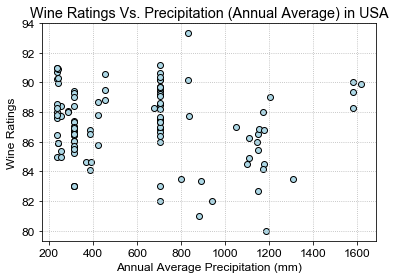

In [48]:
x1 = post_process["Precipitation(mm)"]
y1 = post_process["Wine Ratings"]
plt.scatter(x1, y1, marker="o", facecolors="lightblue", edgecolors="black")
plt.title("Wine Ratings Vs. Precipitation (Annual Average) in USA")
plt.xlabel("Annual Average Precipitation (mm)")
plt.ylabel("Wine Ratings")
plt.grid(linestyle='dotted')
plt.savefig("Ratings_Precip.png",dpi=200)

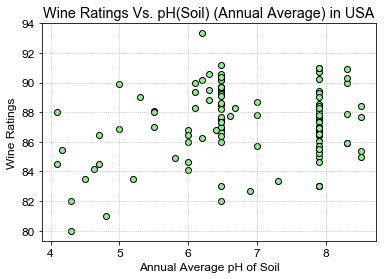

In [49]:
x1 = post_process["pH(Soil)"]
y1 = post_process["Wine Ratings"]
plt.scatter(x1, y1, marker="o", facecolors="lightgreen", edgecolors="black")
plt.title("Wine Ratings Vs. pH(Soil) (Annual Average) in USA")
plt.xlabel("Annual Average pH of Soil")
plt.ylabel("Wine Ratings")
plt.grid(linestyle='dotted')
plt.savefig("Ratings_Soil_pH.png",dpi=200)


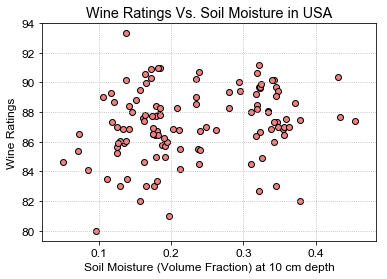

In [51]:
x1 = post_process["Soil Moisture"]
y1 = post_process["Wine Ratings"]
plt.scatter(x1, y1, marker="o", facecolors="lightcoral", edgecolors="black")
plt.title("Wine Ratings Vs. Soil Moisture in USA")
plt.xlabel("Soil Moisture (Volume Fraction) at 10 cm depth")
plt.ylabel("Wine Ratings")
plt.grid(linestyle='dotted')
plt.savefig("Ratings_Soil_Moisture.png",dpi=200)


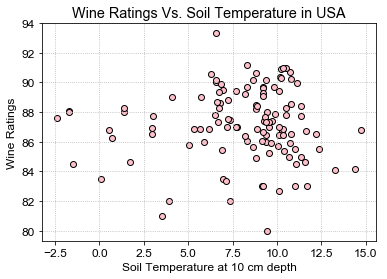

In [53]:
x1 = post_process["Soil Temperature (C) at 10 cm depth"]
y1 = post_process["Wine Ratings"]
plt.scatter(x1, y1, marker="o", facecolors="pink", edgecolors="black")
plt.title("Wine Ratings Vs. Soil Temperature in USA")
plt.xlabel("Soil Temperature at 10 cm depth")
plt.ylabel("Wine Ratings")
plt.grid(linestyle='dotted')
plt.savefig("Ratings_Soil_Temp.png",dpi=200)
